<a href="https://colab.research.google.com/github/ayush2281/Pytorch-for-ML-DL-/blob/main/%F0%9F%97%83_Chapter_4_%E2%80%93_Custom_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🗃 Chapter 4 – Custom Datasets with Pytorch

In the last notebook, notebook 03, we looked at how to build computer vision models on an in-built dataset in PyTorch (FashionMNIST).

The steps we took are similar across many different problems in machine learning.

Find a dataset, turn the dataset into numbers, build a model (or find an existing model) to find patterns in those numbers that can be used for prediction.

PyTorch has many built-in datasets used for a wide number of machine learning benchmarks, however, you'll often want to use your own custom dataset.

What is a custom dataset?
A **custom dataset** is a collection of data relating to a specific problem you're working on.

In essence, a  **custom dataset** can be comprised of almost anything.

For example, if we were building a food image classification app like Nutrify, our custom dataset might be images of food.

Or if we were trying to build a model to classify whether or not a text-based review on a website was positive or negative, our custom dataset might be examples of existing customer reviews and their ratings.

Or if we were trying to build a sound classification app, our custom dataset might be sound samples alongside their sample labels.

Or if we were trying to build a recommendation system for customers purchasing things on our website, our custom dataset might be examples of products other people have bought.

Book version of the course material : https://www.learnpytorch.io/04_pytorch_custom_datasets/

What we're going to cover
We're going to be applying the PyTorch Workflow we covered in notebook 01 and notebook 02 to a computer vision problem.

But instead of using an in-built PyTorch dataset, we're going to be using our own dataset of pizza, steak and sushi images.

The goal will be to load these images and then build a model to train and predict on them

Food 101 dataset : https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

Github repo : https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb

In [1]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.5.0+cu121'

And now let's follow best practice and setup device-agnostic code.



Note: If you're using Google Colab, and you don't have a GPU turned on yet, it's now time to turn one on via Runtime -> Change runtime type -> Hardware accelerator -> GPU. If you do this, your runtime will likely reset and you'll have to run all of the cells above by going Runtime -> Run before.




In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## 1. Get Data
Our dataset is a subset of the food101 dataset.

FOood101 starts 101 different classes of food and 1000 immages per class (750training and 250 testing) .

Our datset  starts with 3 classes of food an only 10% of the image (~75 training 25 testing).

why do this?

when starting out Ml projects , it is important to try thing on small scala and then increase  the scale when necessary the whole point is speed up how fast you can experimeny.

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [5]:
image_path

PosixPath('data/pizza_steak_sushi')

In [6]:
## Becoming one with data (data prepare and data exploration)
import os
def walk_through_dir(dir_path):
  """ Walk though dir_path returning its contents"""

  for   dir_path, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dir_path}'")


In [7]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'


In [8]:
# setup training and test path
train_dir = image_path / "train"
test_dir = image_path / "test"


### 2.1 Visulaizing the image

let's wrote a code
1 get all of the image paths
2. pick a ramdom image path using Python random.choice
3. Get the image of class name  using `pathlib.Path.paraent.stem()`
4. Since we're working with image let's open the image with Python's PIL
5. We'll then show the image and print metadata

In [9]:
image_path

PosixPath('data/pizza_steak_sushi')

Random image path : data/pizza_steak_sushi/train/sushi/3360232.jpg
Image class : sushi
Image width : 512
Image height : 384


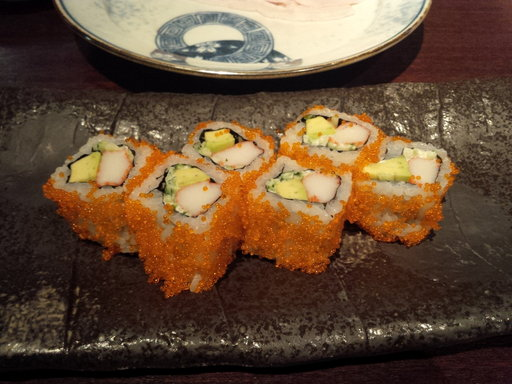

In [10]:
# /content/data/pizza_steak_sushi

import random
from PIL import Image
# Set seed
torch.manual_seed(42)

#1. Get all image path
images_paths_list = list(image_path.glob("*/*/*.jpg"))
images_paths_list


#Pick a random image path

random_image_path = random.choice(images_paths_list)
random_image_path

#3.  get the image class from path name (the image class is the name of the directory where the )

image_class = random_image_path.parent.stem
image_class

#4. Open image
img = Image.open(random_image_path)

#5. print metadata
print(f"Random image path : {random_image_path}")
print(f"Image class : {image_class}")
print(f"Image width : {img.width}")
print(f"Image height : {img.height}")
img


(-0.5, 511.5, 383.5, -0.5)

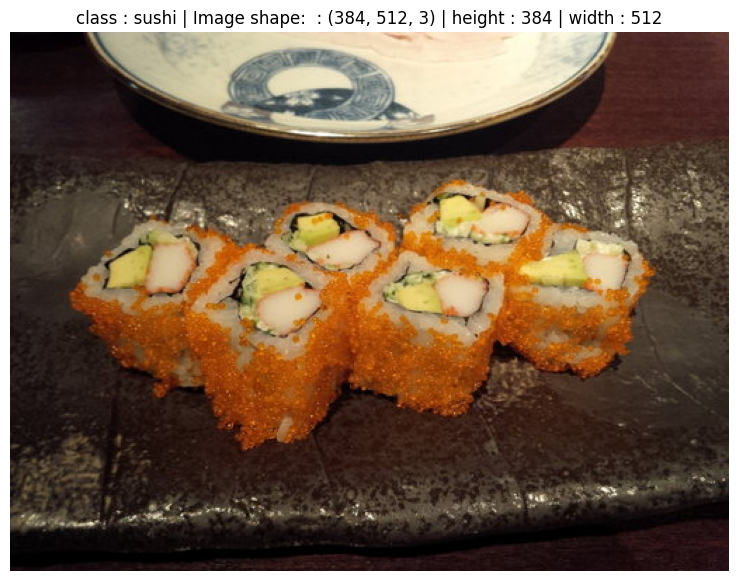

In [11]:
# try to visulaize the image with help of matplotlib

import numpy as np
import matplotlib.pyplot as plt
#turn image into array
img_array = np.asarray(img)
img_array.shape

#  plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_array)
plt.title(f"class : {image_class} | Image shape:  : {img_array.shape} | height : {img.height} | width : {img.width}")
plt.axis(False)

array([[[  8,   6,   9],
        [  8,   6,   9],
        [  8,   6,   9],
        ...,
        [ 97,  56,  50],
        [102,  61,  57],
        [108,  67,  63]],

       [[  3,   1,   4],
        [  3,   1,   4],
        [  3,   1,   4],
        ...,
        [ 97,  56,  50],
        [100,  59,  55],
        [106,  65,  61]],

       [[  4,   2,   5],
        [  3,   1,   4],
        [  3,   1,   4],
        ...,
        [ 97,  56,  50],
        [100,  59,  53],
        [105,  64,  58]],

       ...,

       [[ 16,  10,  12],
        [ 15,   9,  11],
        [ 15,   9,  11],
        ...,
        [ 37,  16,  25],
        [ 34,  13,  22],
        [ 34,  13,  22]],

       [[ 21,  10,  14],
        [ 22,  11,  15],
        [ 23,  12,  16],
        ...,
        [ 37,  16,  25],
        [ 37,  16,  25],
        [ 39,  18,  27]],

       [[ 17,   5,   9],
        [ 17,   5,   9],
        [ 19,   7,  11],
        ...,
        [ 39,  18,  27],
        [ 42,  21,  30],
        [ 45,  24,  33]]], dtype=uint8)
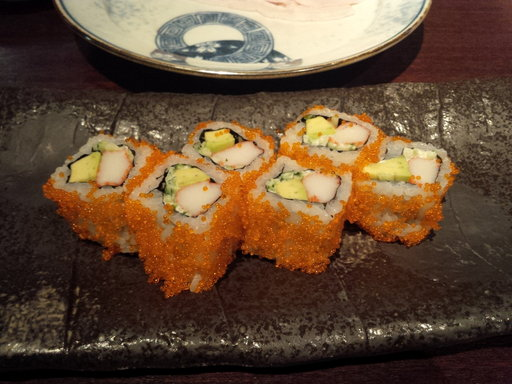

In [12]:
img_array

###3. Transforming data
Now what if we wanted to load our image data into PyTorch?

Before we can use our image data with PyTorch we need to:

1. Turn it into tensors (numerical representations of our images).
2. Turn it into a torch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader, we'll call these Dataset and DataLoader for shor

In [13]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


###3.1 Transforming data with torchvision.transforms¶

We've got folders of images but before we can use them with PyTorch, we need to convert them into tensors.

One of the ways we can do this is by using the torchvision.transforms module.

torchvision.transforms contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for data augmentation (the practice of altering data to make it harder for a model to learn, we'll see this later on) purposes .

To get experience with `torchvision.transforms,` let's write a series of transform steps that:

Resize the images using `transforms.Resize()` (from about 512x512 to 64x64, the same shape as the images on the CNN Explainer website).
Flip our images randomly on the horizontal using `transforms.RandomHorizontalFlip()` (this could be considered a form of data augmentation because it will artificially change our image data).
Turn our images from a PIL image to a PyTorch tensor using `transforms.ToTensor().`
We can compile all of these steps using `torchvision.transforms.Compose().`

In [14]:
# Write a transform for image
data_transforms = transforms.Compose([
    # resize our  image to 64*64
    transforms.Resize((64,64)),
    #Flip the image randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    #turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [15]:
data_transforms(img).shape

torch.Size([3, 64, 64])

Now we've got a composition of transforms, let's write a function to try them out on various images.

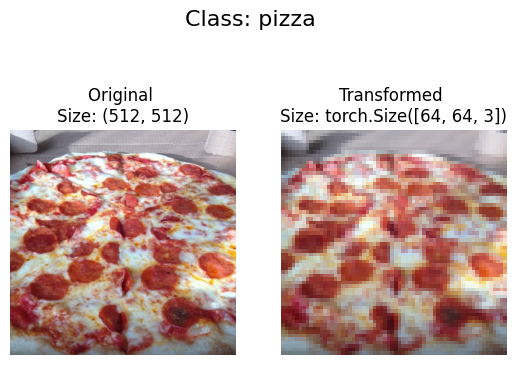

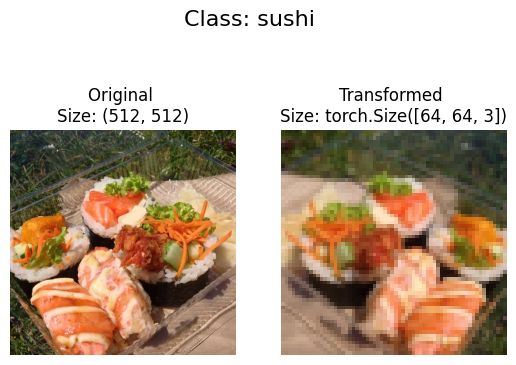

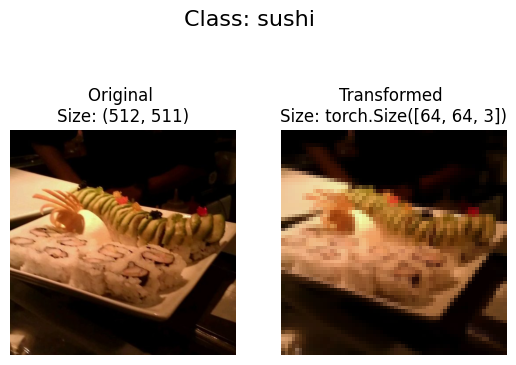

In [16]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(images_paths_list,
                        transform=data_transforms,
                        n=3)

Nice!

We've now got a way to convert our images to tensors using `torchvision.transforms.`

We also manipulate their size and orientation if needed `(some models prefer images of different sizes and shapes).`

Generally, the larger the shape of the image, the more information a model can recover.

For example, an image of size `[256, 256, 3]` will have 16x more pixels than an image of size `[64, 64, 3] ((256*256*3)/(64*64*3)=16)`.

However, the tradeoff is that more pixels requires more computations.



###4. Option 1: Loading Image Data Using ImageFolder
Alright, time to turn our image data into a Dataset capable of being used with PyTorch.

Since our data is in standard image classification format, we can use the class `torchvision.datasets.ImageFolder`.

Where we can pass it the file path of a target image directory as well as a series of transforms we'd like to perform on our images.

Let's test it out on our data folders train_dir and test_dir passing in `transform=data_transform` to turn our images into tensors.

In [17]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transforms)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [18]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [19]:
# Get class name as list
class_names = train_data.classes
class_names


['pizza', 'steak', 'sushi']

In [20]:
# get class name as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [21]:
# chevk the lenghth of dataset
len(train_data), len(test_data)

(225, 75)

In [22]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [23]:

# Index on the train data dataset  to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor\n: {img}")
print(f"Image shape: {img.shape}")
print(f"image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"label datatype: {type(label)}")

Image tensor
: tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

In [24]:

label

0

In [25]:

class_names[label]

'pizza'

Our images are now in the form of a tensor (with shape `[3, 64, 64])` and the labels are in the form of an integer relating to a specific class (as referenced by the class_to_idx attribute).

How about we plot a single image tensor using `matplotlib?`

We'll first have to to permute (rearrange the order of its dimensions) so it's compatible.

Right now our image dimensions are in the format` CHW `(color channels, height, width) but matplotlib prefers HWC (height, width, color channels)

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Shape after permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


(-0.5, 63.5, 63.5, -0.5)

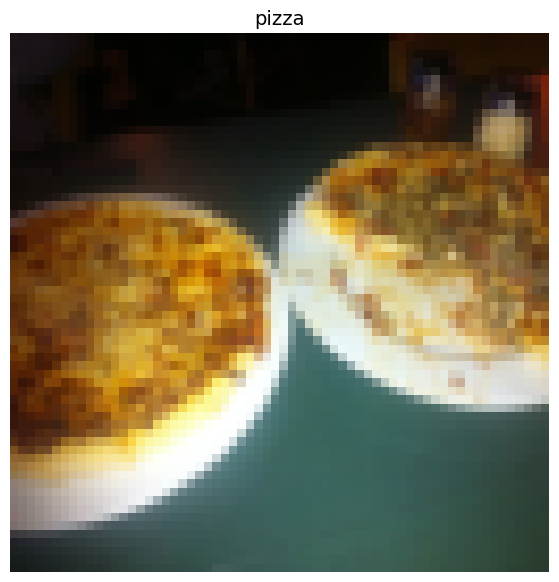

In [26]:

# rearrange the order dimension
img_permute = img.permute(1,2,0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Shape after permute: {img_permute.shape} -> [height, width, color_channels]")
\


# plot the image'
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.title(class_names[label], fontsize=14)
plt.axis(False)


Notice the image is now more pixelated `(less quality`).

This is due to it being resized from `512x512 to 64x64 pixels`.

The intuition here is that if you think the image is harder to recognize what's going on, chances are a model will find it harder to understand too.

###4.1 Turn loaded images into DataLoader's
We've got our images as PyTorch Dataset's but now let's turn them into `DataLoader's`.

We'll do so using `torch.utils.data.DataLoader.`

Turning our Dataset's into `DataLoader's` makes them iterable so a model can go through and learn the relationships between samples and targets (features and labels).

To keep things simple, we'll use a `batch_size=1` and `num_workers=1`.

What's `num_workers?`

Good question.

It defines how many subprocesses will be created to load your data.

Think of it like this, the higher value `num_workers `is set to, the more compute power PyTorch will use to load your data.

Personally, I usually set it to the total number of CPUs on my machine via Python's `os.cpu_count().`

This ensures the `DataLoader` recruits as many cores as possible to load data.

1 batch = 32 data point 32*8 = 256>225 it mean 8 batch for train , and 3*32  = 96 but element is 75 it mean 3 batch for the test datloader

In [27]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78a4ee4b3190>,
 <torch.utils.data.dataloader.DataLoader at 0x78a4ee4b2c80>)


Wonderful!

Now our data is iterable.

Let's try it out and check the shapes.

In [28]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [29]:

len(train_data), len(test_data)

(225, 75)

In [30]:
32*3

96

In [31]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


We could now use these `DataLoader'`s with a training and testing loop to train a model.

But before we do, let's look at another option to load images (or almost any other kind of data).

##5. Option 2: Loading Image Data with a Custom Dataset[link text](https://)

1. Want to be able to load image from file
2. Want to be get the class names from the dataset
3. Want to be able to get classes as a dictionary from the datset

pros:
   * Can create a dataset out of almostr anything
   * Noyt limited to Pytorch pre-built `Dataset` function

Cons:
   * Even though You could create `dataset` out of almost anything , it does'nt mean kit will work...
   * using a custom `dataset` often result iin us writing more code, which could be prone to erros or performance issues



To see this in action, let's work towards replicating `torchvision.datasets ImageFolder()` by subclassing `torch.utils.data.Dataset` (the base class for all `Dataset's` in PyTorch).

We'll start by importing the modules we need:

Python's `os` for dealing with directories (our data is stored in directories).
Python's `pathlib` for dealing with filepaths (each of our images has a unique filepath).
`torch` for all things `PyTorch.`
PIL's `Image` class for loading images.
`torch.utils.data.Dataset` to subclass and create our own custom Dataset.
`torchvision.transforms` to turn our images into tensors.
Various types from Python's `typing` module to add type hints to our code.

In [32]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

Remember how our instances of `torchvision.datasets.ImageFolder()` allowed us to use the `classes` and `class_to_idx` attributes?

In [33]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

###5.1 Creating a helper function to get class names
Let's write a helper function capable of creating a list of class names and a dictionary of class names and their indexes given a directory path.

To do so, we'll:

1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dictionary of numerical labels, one for each class.
Let's see a small example of step 1 before we write the full function.

In [34]:
# setup path for target direc
target_dir = train_dir
print(f"Target directory :{target_dir}")

# Get class names as a list
class_names_founds = sorted([entry.name for entry in list(os.scandir(target_dir))])
class_names_founds

Target directory :data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [35]:
list(os.scandir(target_dir))

[<DirEntry 'sushi'>, <DirEntry 'steak'>, <DirEntry 'pizza'>]

In [36]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

Looking good!

Now let's test out our `find_classes()` function.

In [37]:
find_classes(target_dir)


(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

Woohoo! Looking good!

###5.2 Create a custom Dataset to replicate ImageFolder (create an copy of image folder)
Now we're ready to build our own custom Dataset.

We'll build one to replicate the functionality of `torchvision.datasets.ImageFolder()`.

This will be good practice, plus, it'll reveal a few of the required steps to make your own custom `Dataset.`

It'll be a fair bit of a code... but nothing we can't handle!

Let's break it down:

1. Subclass `torch.utils.data.Dataset.`
2. Initialize our subclass with a `targ_dir parameter (the target data directory)` and transform parameter (so we have the option to transform our data if needed).
3. Create several attributes for :
     * paths (the paths of our target images),
     * transform (the transforms we might like to use, this can be None),
     * classes - a list ofntarget classes
     * `class_to_idx` (from our find_classes() function).
4. Create a function to load images from file and return them, this could be using PIL or `torchvision.io` (for input/output of vision data).
5. Overwrite the __len__ method of `torch.utils.data.Dataset` to return the number of samples in the Dataset, this is recommended but not required. This is so you can call len(Dataset).
6. Overwrite the __getitem__ method of `torch.utils.data.Dataset` to return a single sample from the Dataset, this is required.

In [38]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:

        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)


In [39]:
img , label = train_data[0]
img, label

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,


Woah! A whole bunch of code to load in our images.

This is one of the downsides of creating your own custom `Dataset's.`

However, now we've written it once, we could move it into a `.py` file such as `data_loader.py` along with some other helpful data functions and reuse it later on.

Before we test out our new ImageFolderCustom class, let's create some transforms to prepare our images.

In [40]:
# augment train data
# create transform
from torchvision import transforms
train_transforms = transforms.Compose([transforms.Resize(size = (64,64)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor()
])
# Don't augment test data, only reshape

test_transforms = transforms.Compose([transforms.Resize(size = (64,64)),
                                      transforms.ToTensor()
])


Now comes the moment of truth!

Let's turn our training images (contained in train_dir) and our testing images (contained in test_dir) into Dataset's using our own ImageFolderCustom class.

In [41]:
# test out Image folderCustom
train_data_custom = ImageFolderCustom(targ_dir= train_dir,
                                      transform = train_transforms)

test_data_custom = ImageFolderCustom(targ_dir= test_dir,
                                      transform = test_transforms)

Hmm... no errors, did it work?

Let's try calling len() on our new Dataset's and find the classes and class_to_idx attributes.

In [42]:
train_data_custom , test_data_custom

(<__main__.ImageFolderCustom at 0x78a4ee634700>,
 <__main__.ImageFolderCustom at 0x78a4ee634670>)

In [43]:
len(train_data_custom), len(train_data)

(225, 225)

In [44]:
len(test_data_custom), len(test_data)

(75, 75)

`len(test_data_custom) == len(test_data)` and `len(test_data_custom) == len(test_data)` Yes!!!

t looks like it worked.

We could check for equality with the Dataset's made by the `torchvision.datasets.ImageFolder()` class too.

In [45]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [46]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [47]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


Ho ho!

Look at us go!

Three `True's!`

You can't get much better than that.

How about we take it up a notch and plot some random images to test our __getitem__ override?

##5.3 Create a function to display random images
You know what time it is!

Time to put on our data explorer's hat and visualize, visualize, visualize!

Let's create a helper function called `display_random_images()` that helps us visualize images in our `Dataset's`.

Specifically, it'll:

1. Take in a `Dataset` and a number of other parameters such as `classes` (the names of our target classes), the number of images to display `(n)` and a random seed.
2. To prevent the display getting out of hand, we'll cap n at 10 images.
3. Set the random seed for reproducible plots (if `seed` is set).
4. Get a list of random sample indexes (we can use Python's `random.sample()` for this) to plot.
5. Setup a` matplotlib plot`.
6. Loop through the random sample indexes found in step 4 and plot them with `matplotlib.`
7. Make sure the sample images are of shape `HWC` (height, width, color channels) so we can plot them.

In [48]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

hat a good looking function!

Let's test it out first with the Dataset we created with `torchvision.datasets.ImageFolder().`

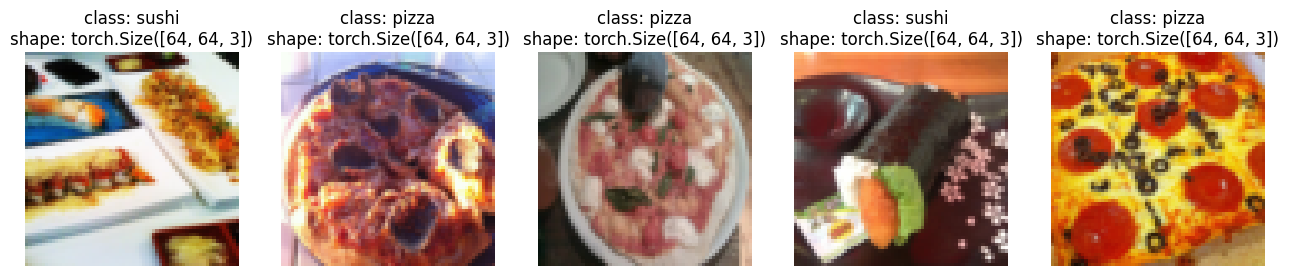

In [49]:
# display random images from images folder createdd dataset
display_random_images(train_data,
                      n=5,
                      classes= class_names,
                      seed =42)

And now with the Dataset we created with our own `ImageFolderCustom.`

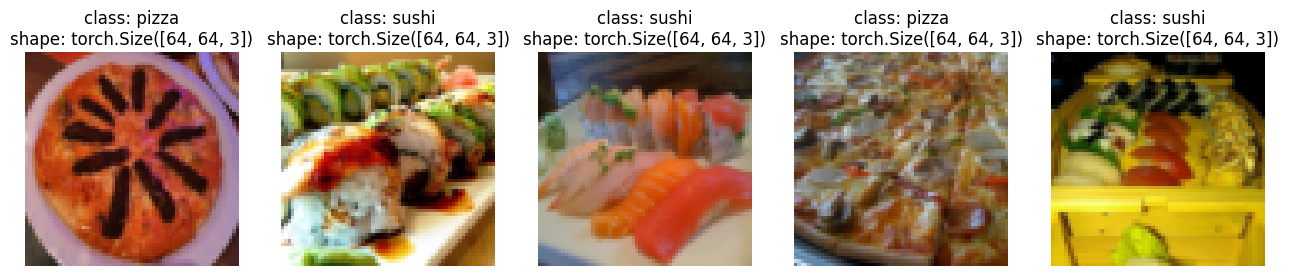

In [50]:
# display randomm images fro the ImageFolderCustom dataset
display_random_images(train_data_custom,
                      n=5,
                      classes= class_names,
                      seed =42)

Nice!!!

Looks like our `ImageFolderCustom` is working just as we'd like it to.

###5.4 Turn custom loaded images into DataLoader's
We've got a way to turn our raw images into Dataset's `(features mapped to labels or X's mapped to y's)` through our ImageFolderCustom class.

Now how could we turn our custom Dataset's into `DataLoader's`?

If you guessed by using `torch.utils.data.DataLoader()`, you'd be right!

Because our custom Dataset's subclass torch.utils.data.Dataset, we can use them directly with `torch.utils.data.DataLoader()`.

And we can do using very similar steps to before except this time we'll be using our custom created `Dataset's.`

In [51]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset = train_data_custom,
                                     batch_size = BATCH_SIZE,
                                     num_workers =  NUM_WORKERS,
                                     shuffle = True)

test_dataloader_custom = DataLoader(dataset = test_data_custom,
                                     batch_size = BATCH_SIZE,
                                     num_workers = NUM_WORKERS,
                                     shuffle = True)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x78a4ee4b14e0>,
 <torch.utils.data.dataloader.DataLoader at 0x78a4ee4b2e90>)

Do the shapes of the samples look the same?



In [52]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])



They sure do!

Let's now take a look at some other forms of data transforms.

###6. Other forms of transforms (data augmentation)
We've seen a couple of transforms on our data already but there's plenty more.

You can see them all in the `torchvision.transforms` documentation.

The purpose of tranforms is to alter your images in some way.

That may be turning your images into a tensor (as we've seen before).

Or cropping it or randomly erasing` a portion or `randomly rotating them.``

Doing these kinds of transforms is often referred to as __data augmentation.__

Data augmentation is the process of altering your data in such a way that you artificially increase the diversity of your training set.

Training a model on this artificially altered dataset hopefully results in a model that is capable of better generalization `(the patterns it learns are more robust to future unseen examples)`.

You can see many different examples of data augmentation performed on images using `torchvision.transforms` in PyTorch's Illustration of Transforms example.

But let's try one out ourselves.

Machine learning is all about harnessing the power of randomness and research shows that random transforms `(like transforms.RandAugment()` and `transforms.TrivialAugmentWide())` generally perform better than hand-picked transforms.

The idea behind `TrivialAugment` is... well, trivial.

You have a set of transforms and you randomly pick a number of them to perform on an image and at a random magnitude between a given range (a higher magnitude means more instense).

The Pytorch Team even : https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#break-down-of-key-accuracy-improvements

__Data augmentation__ is a technique used in machine learning to increase the size and diversity of a dataset by making small changes to the existing data. This helps improve the performance of models by providing them with more varied examples to learn from.

Imagine you have a set of images of traffic signs, but you don’t have enough images to train a good model. With data augmentation, you can create new images by slightly altering the original ones. Here are some common ways to do this:

1. Flipping: Turn the image horizontally or vertically.
2. Rotating: Rotate the image by a small angle.
3. Cropping: Cut out a part of the image.
4. Scaling: Resize the image.
5. Changing Brightness/Contrast: Adjust the brightness or contrast levels.
6. Adding Noise: Introduce random noise to the image.

https://pytorch.org/vision/main/generated/torchvision.transforms.TrivialAugmentWide.html

In [53]:
# let's look at trivailaugment
from torchvision import transforms
from torchvision.transforms import TrivialAugmentWide

train_transform = transforms.Compose([
                                   transforms.Resize(size = (224,224)),
                                   transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                   transforms.ToTensor()
])

test_transform = transforms.Compose([
                                   transforms.Resize(size = (224,224)),
                                   transforms.ToTensor()
])

**Note**: You usually don't perform data augmentation on the test set. The idea of data augmentation is to to artificially increase the diversity of the training set to better predict on the testing set.

However, you do need to make sure your test set images are transformed to tensors. We size the test images to the same size as our training images too, however, inference can be done on different size images if necessary (though this may alter performance).

Beautiful, now we've got a training transform (with data augmentation) and test transform (without data augmentation).

Let's test our data augmentation out!

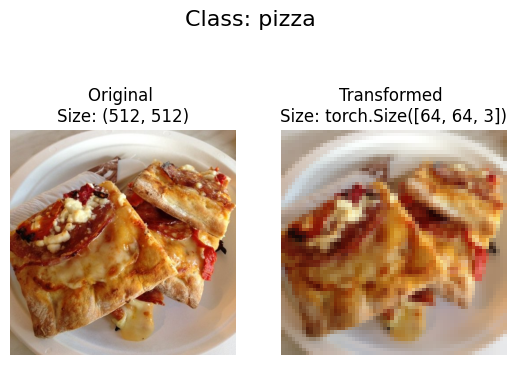

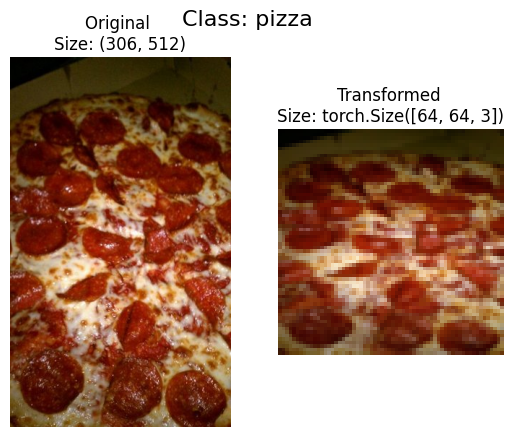

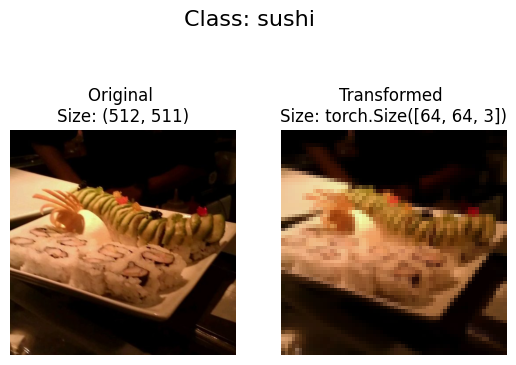

In [54]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

try running the cell above a few times and seeing how the original image changes as it goes through the transform.

###7. Model 0: TinyVGG without data augmentation
Alright, we've seen how to turn our data from images in folders to transformed tensors.

Now let's construct a computer vision model to see if we can classify if an image is of pizza, steak or sushi.

To begin, we'll start with a simple transform, only resizing the images to `(64, 64)` and turning them into tensors.

Let's replicate TintVGG archtecture from the CNN Explainer website: https://poloclub.github.io/cnn-explainer/

###7.1 Creating transforms and loading data for Model 0

In [55]:
#create a simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()
])


Excellent, now we've got a simple transform, let's:

1. Load the data, turning each of our training and test folders first into a Dataset with `torchvision.datasets.ImageFolder()`
2. Then into a DataLoader using `torch.utils.data.DataLoader()`.
We'll set the `batch_size=32` and `num_workers `to as many CPUs on our machine (this will depend on what machine you're using).

In [56]:
# Load and transforn data
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data_sample = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=simple_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data_sample = datasets.ImageFolder(root=test_dir,
                                 transform=simple_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

# 2. turn the dataset intp dataloader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()


train_dataloader_sample = DataLoader(dataset = train_data_sample,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True,
                                     num_workers = NUM_WORKERS)

test_dataloader_sample = DataLoader(dataset = test_data_sample,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True,
                                     num_workers = NUM_WORKERS)




Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


ataLoader's created!

Let's build a model.

## 7.2 7.2 Create TinyVGG model class
In notebook 03, we used the TinyVGG model from the CNN Explainer website.

Let's recreate the same model, except this time we'll be using color images instead of grayscale (in_channels=3 instead of in_channels=1 for RGB pixels).

In [57]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=0), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

Note: One of the ways to speed up deep learning models computing on a GPU is to leverage operator fusion.

This means in the `forward()` method in our model above, instead of calling a layer block and reassigning `x`every time, we call each block in succession (see the final line of the forward() method in the model above for an example).

This saves the time spent reassigning x `(memory heavy)` and focuses on only computing on `x.`

See Making Deep Learning Go Brrrr From First Principles by Horace He for more ways on how to speed up machine learning models.https://horace.io/brrr_intro.html

ow that's a nice looking model!

How about we test it out with a forward pass on a single image?

In [58]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of coolor channel in our image data
                  hidden_units = 10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

###7.3 Try a forward pass on a single image (to test the model)¶

In [59]:
# Get a single image batch
image_batch , label_batch = next(iter(train_dataloader_sample))
image_batch.shape, label_batch.shape

# Single image batch shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [60]:
# try a forward bias
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

7.4 Use torchinfo to get an idea of the shapes going through our model
Printing out our model with `print(model)` gives us an idea of what's going on with our model.

And we can print out the shapes of our data throughout the `forward()` method.

However, a helpful way to get information from our model is to use torchinfo.

torchinfo comes with a `summary()` method that takes a `PyTorch model` as well as an input_shape and returns what happens as a tensor moves through your model.

In [61]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64,64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia


Nice!

The output of torchinfo.summary() gives us a whole bunch of information about our model.

Such as Total params, the total number of parameters in our model, the Estimated Total Size (MB) which is the size of our model.

You can also see the change in input and output shapes as data of a certain input_size moves through our model.

Right now, our parameter numbers and total model size is low.

This because we're starting with a small model.

In [62]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


Woohoo! `train_step()` function done.

Now let's do the same for the `test_step()` function.

The main difference here will be the `test_step()` won't take in an optimizer and therefore won't perform gradient descent.

But since we'll be doing inference, we'll make sure to turn on the torch.`inference_mode()` context manager for making predictions.

In [63]:
def test_step(model = torch.nn.Module,
              dataloader = torch.utils.data.DataLoader,
              loss_fn = torch.nn.Module):
  # put the model in eval mode
  model.eval()

  # setup test loss and test accuracy
  test_loss , test_acc = 0,0

  # Turn on inferencce context manager
  with torch.inference_mode():
    # loop though dataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # send data to target device
      X = X.to(device)
      y = y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


Excellent!!


###7.6 Creating a train() function to combine train_step() and test_step()

Now we need a way to put our train_step() and test_step() functions together.

To do so, we'll package them up in a train() function.

This function will train the model as well as evaluate it.

Specificially, it'll:

1. Take in a model, a `DataLoader` for training and test sets, an optimizer, a loss function and how many epochs to perform each train and test step for.
2. Create an empty results dictionary for `train_loss, train_acc, test_loss and test_acc` values (we can fill this up as training goes on).
3. Loop through the training and test step functions for a number of epochs.
Print out what's happening at the end of each epoch.
5. Update the empty results dictionary with the updated metrics each epoch.
6. Return the filled


To keep track of the number of epochs we've been through, let's import `tqdm` from `tqdm.auto` (tqdm is one of the most popular progress bar libraries for Python and `tqdm.auto` automatically decides what kind of progress bar is best for your computing environment, e.g. Jupyter Notebook vs. Python script).

In [64]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

###7.7 Train and Evaluate Model 0
Alright, alright, alright we've got all of the ingredients we need to train and evaluate our model.

Time to put our `TinyVGG model`, `DataLoader's and train()` function together to see if we can build a model capable of discerning between pizza, steak and sushi!

Let's recreate model_0 `(we don't need to but we will for completeness)` then call our train() function passing in the necessary parameters.

To keep our experiments quick, we'll train our model for 5 epochs (though you could increase this if you want).

As for an optimizer and loss function, we'll use torch.nn.CrossEntropyLoss() (since we're working with multi-class classification data) and `torch.optim.Adam()` with a learning rate of 1e-3 respectively.

To see how long things take, we'll import Python's `timeit.default_timer()` method to calculate the training time.

In [65]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_sample,
                        test_dataloader=test_dataloader_sample,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0979 | test_acc: 0.3409
Epoch: 2 | train_loss: 1.0835 | train_acc: 0.4453 | test_loss: 1.0778 | test_acc: 0.4223
Epoch: 3 | train_loss: 1.1063 | train_acc: 0.2812 | test_loss: 1.0818 | test_acc: 0.3826
Epoch: 4 | train_loss: 1.0755 | train_acc: 0.4766 | test_loss: 1.0778 | test_acc: 0.5047
Epoch: 5 | train_loss: 1.0664 | train_acc: 0.4023 | test_loss: 1.0519 | test_acc: 0.5038
Total training time: 25.087 seconds


hmm...

It looks like our model performed pretty poorly.

But that's okay for now, we'll keep persevering.

What are some ways you could potentially improve it?

###7.8 Plot the loss curves of Model 0
From the print outs of our `model_0` training, it didn't look like it did too well.

But we can further evaluate it by plotting the model's loss curves.

Loss curves show the model's results over time.

And they're a great way to see how your model performs on different datasets (e.g. training and test).

Let's create a function to plot the values in our `model_0_results` dictionary.


In [66]:

# get the model_0 results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [67]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

We'll need to extract each of these keys and turn them into a plot.



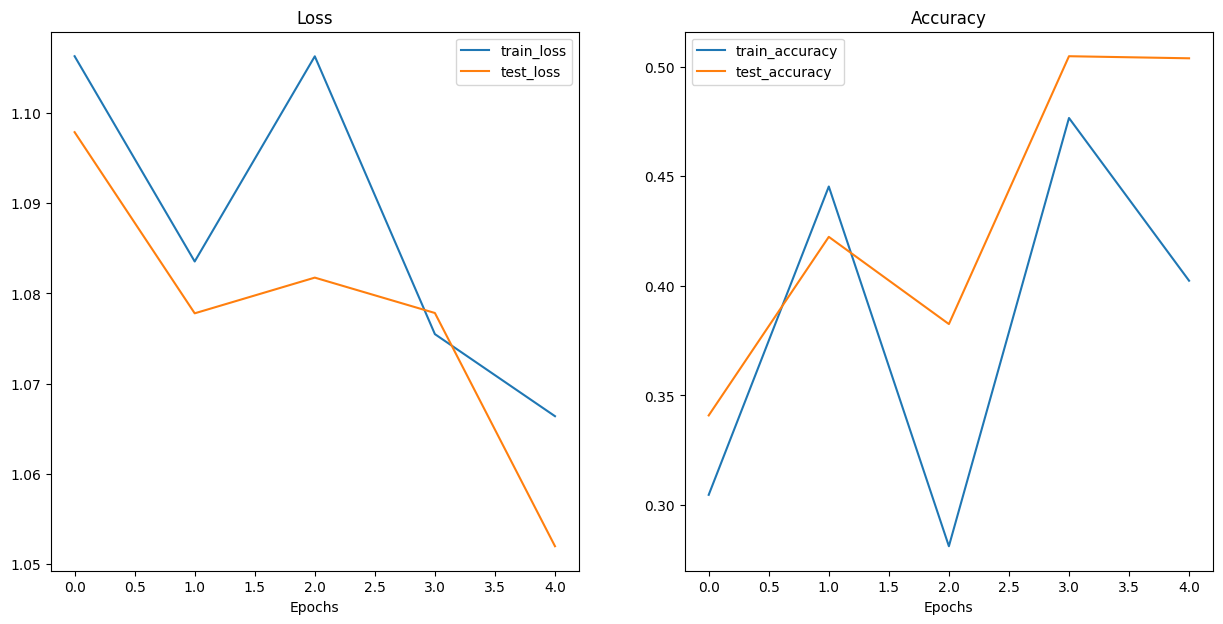

In [68]:
plot_loss_curves(model_0_results)

Woah.

Looks like things are all over the place...

But we kind of knew that because our model's print out results during training didn't show much promise.

You could try training the model for longer and see what happens when you plot a loss curve over a longer time horizon.


###8. What should an ideal loss curve look like?
Looking at training and test loss curves is a great way to see if your model is **overfitting**.

An overfitting model is one that performs better (often by a considerable margin) on the training set than the validation/test set.

If your training loss is far lower than your test loss, your model is overfitting.
**bold text**
As in, it's learning the patterns in the training too well and those patterns aren't generalizing to the test data.

The other side is when your training and test loss are not as low as you'd like, this is considered **underfitting**.

The ideal position for a training and test loss curve is for them to line up closely with each other.


###8.1 How to deal with overfitting
Since the main problem with overfitting is that your model is fitting the training data too well, you'll want to use techniques to "reign it in".

A common technique of preventing overfitting is known as **regularization**.

I like to think of this as "making our models more regular", as in, capable of fitting more kinds of data.

https://developers.google.com/machine-learning/crash-course/overfitting/data-characteristics

###9. Model 1: TinyVGG with Data Augmentation
Time to try out another model!

This time, let's load in the data and use data augmentation to see if it improves our results in anyway.

First, we'll compose a training transform to include transforms.TrivialAugmentWide() as well as resize and turn our images into tensors.

We'll do the same for a testing transform except without the data augmentation

###9.1 Create transform with data augmentation¶


In [69]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

Wonderful!

Now let's turn our images into Dataset's using `torchvision.datasets.ImageFolder()` and then into DataLoader's with `torch.utils.data.DataLoader().`

###9.2 Create train and `test Dataset's and DataLoader's`
We'll make sure the train Dataset uses the train_transform_trivial_augment and the test Dataset uses the test_transform.

In [70]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

And we'll make `DataLoader's` with a `batch_size=32` and with `num_worker`s set to the number of CPUs available on our machine (we can get this using Python's `os.cpu_count()).`

In [71]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78a4ef14f520>,
 <torch.utils.data.dataloader.DataLoader at 0x78a4ee4b2c80>)


###9.3 Construct and train Model 1
Data loaded!

Now to build our next `model, model_1,` we can reuse our `TinyVGG` class from before.

We'll make sure to send it to the target device.

In [72]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

Model ready!

Time to train!

Since we've already got functions for the training loop `(train_step())` and testing loop `(test_step())` and a function to put them together in `train()`, let's reuse those.

We'll use the same setup as `model_0` with only the `train_dataloader` parameter varying:

Train for 5 epochs.
Use `train_dataloader=train_dataloader_augmented` as the training data in train().
Use `torch.nn.CrossEntropyLoss()` as the loss function (since we're working with multi-class classification).
Use `torch.optim.Adam() with lr=0.001` as the learning rate as the optimizer.

In [73]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1049 | train_acc: 0.2500 | test_loss: 1.1019 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0807 | train_acc: 0.4258 | test_loss: 1.1261 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0712 | train_acc: 0.4258 | test_loss: 1.1593 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1253 | train_acc: 0.3047 | test_loss: 1.1581 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0865 | train_acc: 0.4258 | test_loss: 1.1554 | test_acc: 0.3333
Total training time: 11.976 seconds



Hmm...

It doesn't look like our model performed very well again.

Let's check out its loss curves.

###9.4 Plot the loss curves of Model 1

> Add blockquote


Since we've got the results of model_1 saved in a results dictionary, model_1_results, we can plot them using plot_loss_curves()

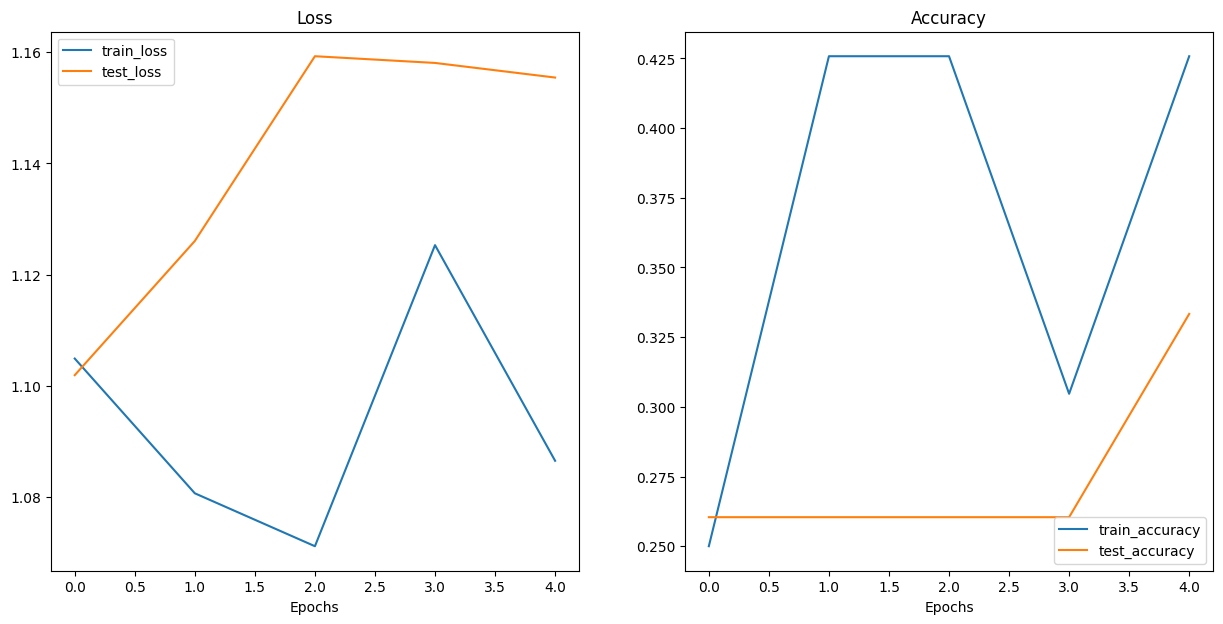

In [74]:
plot_loss_curves(model_1_results)


Wow...

These don't look very good either...

Is our model `underfitting` or `overfitting?`

Or both?

Ideally we'd like it have higher accuracy and lower loss right?

What are some methods you could try to use to achieve these?

###10. Compare model results
Even though our models our performing quite poorly, we can still write code to compare them.

Let's first turn our model results into pandas DataFrames.

there is few different way to do this:
1. hard coiding (what's we are doing).😂😂
2. Pytorch + Tensorboard - https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html
3. Weights and Biases - https://wandb.ai/site/
4. MLFLOW -https://mlflow.org/

In [75]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.097892,0.340909
1,1.083543,0.445312,1.077791,0.422348
2,1.106311,0.281250,1.081752,0.382576
3,1.075482,0.476562,1.077827,0.504735
4,1.066376,0.402344,1.051948,0.503788


And now we can write some plotting code using matplotlib to visualize the results of `model_0` and `model_1` together.

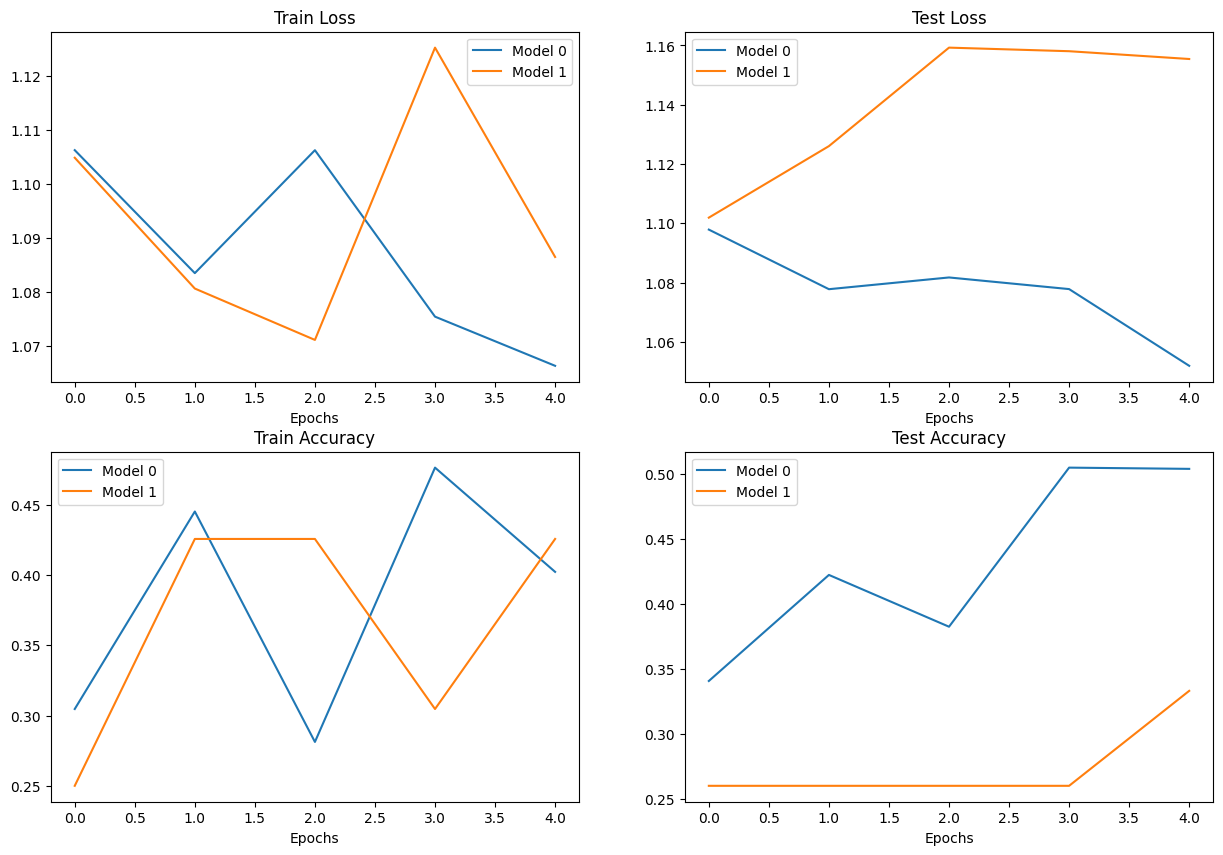

In [76]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

t looks like our models both performed equally poorly and were kind of sporadic (the metrics go up and down sharply).

If you built model_2, what would you do differently to try and improve performance?

###1. Make a prediction on a custom image
If you've trained a model on a certain dataset, chances are you'd like to make a prediction on your own custom data.

In our case, since we've trained a model on pizza, steak and sushi images, how could we use our model to make a prediction on one of our own images?

To do so, we can load an image and then preprocess it in a way that matches the type of data our model was trained on.

In other words, we'll have to convert our own custom image to a tensor and make sure it's in the right datatype before passing it to our model.

Let's start by downloading a custom image.

Since our model predicts whether an image contains pizza, steak or sushi, let's download a photo of my Dad giving two thumbs up to a big pizza from the Learn PyTorch for Deep Learning GitHub.

In [77]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

###11.1 Loading in a custom image with PyTorch
Excellent!

Looks like we've got a custom image downloaded and ready to go at `data/04-pizza-dad.jpeg`.

Time to load it in.

PyTorch's `torchvision` has several input and output ("IO" or "io" for short) methods for reading and writing images and video in `torchvision.io.`

Since we want to load in an image, we'll use torchvision.io.read_image().

This method will read a JPEG or PNG image and turn it into a 3 dimensional RGB or grayscale torch.Tensor with values of datatype uint8 in range `[0, 255].`

Let's try it out..1 Loading in a custom image with PyTorch
Excellent!

Looks like we've got a custom image downloaded and ready to go at data/04-pizza-dad.jpeg.

Time to load it in.

PyTorch's torchvision has several input and output ("IO" or "io" for short) methods for reading and writing images and video in torchvision.io.

Since we want to load in an image, we'll use torchvision.io.read_image().

This method will read a JPEG or PNG image and turn it into a 3 dimensional RGB or grayscale torch.Tensor with values of datatype uint8 in range [0, 255].

Let's try it out.

In [78]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

Nice! Looks like our image is in tensor format, however, is this image format compatible with our model?

Our `custom_image` tensor is of datatype `torch.uint8` and its values are between [0, 255].`

But our model takes image tensors of datatype `torch.float32` and with values between [0, 1].

So before we use our custom image with our model, **we'll need to convert it to the same format as the data our model is trained on.**
If we don't do this, our model will error.

In [82]:
# Try to make a prediction on image in uint8 format (this will error)
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same


If we try to make a prediction on an image in a different datatype to what our model was trained on, we get an error like the following:

In [83]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

###11.2 Predicting on custom images with a trained PyTorch model
Beautiful, it looks like our image data is now in the same format our model was trained on.

Except for one thing...

It's `shape.`

Our model was trained on images with shape `[3, 64, 64],` whereas our custom image is currently `[3, 4032, 3024].`

How could we make sure our custom image is the same shape as the images our model was trained on?

Are there any `torchvision.transforms` that could help?

Before we answer that question, let's plot the image with `matplotlib` to make sure it looks okay, remember we'll have to permute the dimensions from `CHW to HWC` to suit `matplotlib's` requirements.

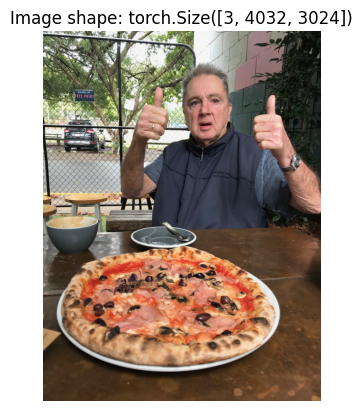

In [85]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

Two thumbs up!

Now how could we get our image to be the same size as the images our model was trained on?

One way to do so is with torchvision.transforms.Resize().

Let's compose a transform pipeline to do so.

In [89]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


In [90]:
custom_image.shape , custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 4032, 3024]), torch.Size([1, 3, 64, 64]))

Woohoo!

Let's finally make a prediction on our own custom image.

In [91]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

Oh my goodness...

Despite our preparations our custom image and model are on different devices.

And we get the error:

Let's fix that by putting our custom_image_transformed on the target device.



In [92]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)


What now?

It looks like we're getting a shape error.

Why might this be?

We converted our custom image to be the same size as the images our model was trained on...

Oh wait...

There's one dimension we forgot about.

The batch size.

Our model expects image tensors with a batch size dimension at the start (NCHW where N is the batch size).

Except our custom image is currently only CHW.

We can add a batch size dimension using torch.unsqueeze(dim=0) to add an extra dimension our image and finally make a prediction.

Essentially we'll be telling our model to predict on a single image (an image with a batch_size of 1).

In [93]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])



Yes!!!

It looks like it worked!

**Note**: What we've just gone through are three of the classical and most common deep learning and PyTorch issues:

1. Wrong datatypes - our model expects torch.float32 where our original custom image was uint8.
2. Wrong device - our model was on the target device (in our case, the GPU) whereas our target data hadn't been moved to the target device yet.
3. Wrong shapes - our model expected an input image of shape [N, C, H, W] or `[batch_size, color_channels, height, width]` whereas our custom image tensor was of shape `[color_channels, height, width].`
Keep in mind, these errors aren't just for predicting on custom images.

They will be present with almost every kind of data type (text, audio, structured data) and problem you work with.


Alright, these are still in logit form (the raw outputs of a model are called logits).

Let's convert them from logits -> prediction probabilities -> prediction labels.

In [94]:
custom_image_pred

tensor([[ 0.0781,  0.0379, -0.2067]])

now let's take a look at our model's predictions.

In [97]:
# Convert logits --> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs


tensor([[0.3686, 0.3541, 0.2773]])

In [96]:
# Convert prediction probabilities -> prediction labels

custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_label

tensor([0])

In [98]:
class_names[custom_image_pred_label]

'pizza'

Having prediction probabilities this similar could mean a couple of things:

1. The model is trying to predict all three classes at the same time (there may be an image containing pizza, steak and sushi).
2. The model doesn't really know what it wants to predict and is in turn just assigning similar values to each of the classes.


our case is number 2, since our model is poorly trained, it is basically guessing the prediction.

###11.3 Putting custom image prediction together: building a function
Doing all of the above steps every time you'd like to make a prediction on a custom image would quickly become tedious.

So let's put them all together in a function we can easily use over and over again.

Specifically, let's make a function that:

1. Takes in a target image path and converts to the right datatype for our model (torch.float32).
2. Makes sure the target image pixel values are in the range [0, 1].
3. Transforms the target image if necessary.
4. Makes sure the model is on the target device.
5. Makes a prediction on the target image with a trained model (ensuring the image is the right size and on the same device as the model).
6. Converts the model's output logits to prediction probabilities.
7. Converts the prediction probabilities to prediction labels.
8. Plots the target image alongside the model prediction and prediction probability.
A fair few steps but we've got this!

In [99]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

What a nice looking function, let's test it out.



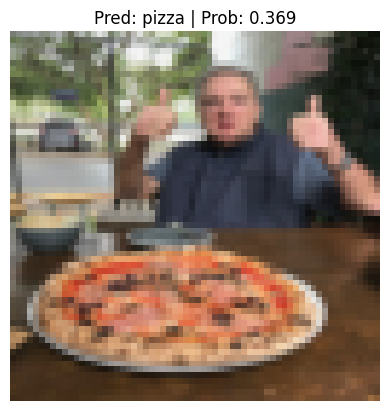

In [100]:
# pred on the custom data
pred_and_plot_image(model=model_1,
                    image_path = custom_image_path,
                    class_names = class_names,
                    transform = custom_image_transform,
                    device = device)

Two thumbs up again!

Looks like our model got the prediction right just by guessing.

This won't always be the case with other images though...

The image is pixelated too because we resized it to `[64, 64]` using `custom_image_transform`.


Main takeaways
We've covered a fair bit in this module.

Let's summarise it with a few dot points.

* PyTorch has many in-built functions to deal with all kinds of data, from vision to text to audio to recommendation systems.
* If PyTorch's built-in data loading functions don't suit your requirements, you can write code to create your own custom datasets by subclassing torch.`utils.data.Dataset.`
* `torch.utils.data.DataLoader's` in PyTorch help turn your `Dataset's` into iterables that can be used when training and testing a model.
* A lot of machine learning is dealing with the balance between **overfitting** and **underfitting** (we discussed different methods for each above, so a good exercise would be to research more and writing code to try out the different techniques).
* Predicting on your own custom data with a trained model is possible, as long as you format the data into a similar format to what the model was trained on. Make sure you take care of the three big PyTorch and deep learning errors:

a. **Wrong datatypes** - Your model expected `torch.float32` when your data is `torch.uint8.`

b. **Wrong data shapes** - Your model expected `[batch_size, color_channels, height, width]` when your data is `[color_channels, height, width]`.

c. **Wrong devices** - Your model is on the GPU but your data is on the CPU.